Here I want to do generations, patching theads the while time 

Specifically, i want to generate with a

In [1]:
from tl_tools import *
from residual_stream_collection_tools import format_prompt

/workspace/reasoning_vector_research/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.set_grad_enabled(False)

In [3]:
model = load_llama8br1()

Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  4.69it/s]


Loaded pretrained model meta-llama/Llama-3.1-8B into HookedTransformer


In [4]:
model.to_tokens("hi whats up")

tensor([[128000,   6151,  41209,    709]], device='cuda:0')

In [5]:
model.blocks[2].attn.hook_k

HookPoint()

In [6]:
utils.get_act_name(model, 2, "attention")

TypeError: argument of type 'HookedTransformer' is not iterable

In [114]:
from typing import List, Tuple, Union, Dict

def generate_with_patching(
    prompt_base: str,
    prompt_patch: str,
    target_head: list[tuple[int, int]] | tuple[int, int],
    max_new_tokens: int,
    base_mode: str = "reasoning",
    do_sample: bool = False,
    scale=1.0,
) -> str:
    """
    Generate text in two stages:
      1) “Base” generation on prompt_base, collecting activations of target_head(s).
      2) “Patch” generation on prompt_patch, injecting those collected activations.

    Args:
        prompt_base: the base prompt. We generate on this until either </think> (if base_mode="reasoning")
                     or until EOS (if base_mode="answering"), capturing the specified head activations.
        prompt_patch: the new prompt. We re-generate from scratch on this, but at each layer/head in
                     target_head we override (or add to) the model’s computed head-output with the stored
                     activations from stage 1.
        target_head: either a single (layer_idx, head_idx) tuple or a list of such tuples. All of these
                     heads will be patched in parallel.
        max_new_tokens: upper bound on how many tokens stage 1 (and stage 2) are allowed to generate.
        base_mode: "reasoning" or "answering". If "reasoning", stage 1 stops generation at the </think> token.
                   If "answering", stage 1 stops at the model’s default EOS token.
        do_sample: pass through to both calls to model.generate (i.e. sampling vs. greedy).
        scale: the scale factor for the output head patch

    Returns:
        The decoded string from the “patched” generation (stage 2).
    """

    #### Assumptions ####
    # 1. A global `model: HookedTransformer` is already defined and .eval()’d.
    # 2. A global `stop_think_id: int` is already defined (the token ID for "</think>").
    #    If base_mode=="reasoning", we use stop_think_id as eos_token_id in stage 1.
    #    Otherwise we use model.tokenizer.eos_token_id.
    #
    # If these globals aren’t present, you must define them before calling:
    #   model = HookedTransformer.from_pretrained("gpt2")
    #   model.eval()
    #   stop_think_id = model.tokenizer.encode("</think>")[-1]

    # ------------- 1. Normalize target_head into a list -------------
    if isinstance(target_head, tuple):
        heads: List[tuple[int, int]] = [target_head]
    else:
        heads = target_head
    
    model.eval()

    # Build a mapping from layer_idx -> list of head_idx for convenience
    layer_to_heads: Dict[int, List[int]] = {}
    for (layer_idx, head_idx) in heads:
        layer_to_heads.setdefault(layer_idx, []).append(head_idx)

    # ------------- 2. Stage 1: Collect activations -------------------
    # We will store, for each (layer, head), a Python list of torch.Tensor:
    #   collected[(layer, head)][0] is the activation for the ENTIRE prompt_base encoding (shape (1, prompt_len, head_dim)),
    #   collected[(layer, head)][i] for i>=1 is the activation for the i-th newly generated token (shape (1, 1, head_dim)).
    collected: Dict[tuple[int, int], List[torch.Tensor]] = {
        (layer, head): [] for (layer, head) in heads
    }
    save_hooks: List[Tuple[str, callable]] = []

    for layer_idx, head_list in layer_to_heads.items():
        hook_name = f"blocks.{layer_idx}.attn.hook_z"

        def make_save_hook(layer_idx: int, head_list: List[int]):
            def save_hook(
                activation: torch.Tensor,  # shape (1, seq_len, n_heads, head_dim) or (1, seq_len, d_model)
                hook=None                  # catch the extra keyword that TransformerLens passes
            ) -> torch.Tensor:
                # Depending on whether we’re on hook_attn_heads vs hook_z, activation
                # could be 4‐D or 3‐D. For simplicity, assume hook_attn_heads here:
                for head_idx in head_list:
                    # slice out activation[:, :, head_idx, :]
                    slice_out = activation[:, :, head_idx, :].detach().cpu().clone()
                    collected[(layer_idx, head_idx)].append(slice_out)
                return activation
            return save_hook

        fn = make_save_hook(layer_idx, head_list)
        model.add_hook(hook_name, fn)
        save_hooks.append((hook_name, fn))

    # Decide which eos to use in stage 1
    if base_mode == "reasoning":
        eos_id_stage1 = model.tokenizer.encode("</think>")[-1]
    else:
        eos_id_stage1 = model.tokenizer.eos_token_id

    # Run stage 1 generation
    base_generation = model.generate(
        prompt_base,
        max_new_tokens = max_new_tokens,
        do_sample       = do_sample,
        eos_token_id    = eos_id_stage1,
    )

    print(base_generation)

    
    # Remove all stage-1 save hooks
    model.reset_hooks()

    # ------------- 3. Process collected activations ---------------------
    # Compute prompt_base length (number of tokens in the original prompt)
    prompt_base_toks  = model.to_tokens(prompt_base)  # shape (1, prompt_base_len)
    prompt_base_len   = prompt_base_toks.shape[1]

    # For each (layer, head), we expect:
    #   collected[(layer, head)][0].shape == (1,  prompt_base_len, head_dim)
    #   collected[(layer, head)][i].shape == (1, 1, head_dim) for i>=1, up to i = num_generated_stage1.
    #
    # Build two structures:
    #   stored_first[(layer, head)]  -> the first element ( Tensor shape (1, prompt_base_len, head_dim) )
    #   decoded_acts[(layer, head)]  -> Python list of Tensors shape (head_dim,) for each generated token
    stored_first: Dict[tuple[int, int], torch.Tensor] = {}
    decoded_acts: Dict[tuple[int, int], List[torch.Tensor]] = {}

    for (layer_idx, head_idx) in heads:
        lst = collected[(layer_idx, head_idx)]
        if len(lst) == 0:
            raise RuntimeError(f"No activations collected for head {(layer_idx, head_idx)}!")
        # First element: full-prompt encoding
        stored_first[(layer_idx, head_idx)] = lst[0]  # shape (1, prompt_base_len, head_dim)
        # Subsequent elements: each is shape (1,1,head_dim); squeeze to (head_dim,)
        subsequent = [lst[i].squeeze(0).squeeze(0) for i in range(1, len(lst))]
        decoded_acts[(layer_idx, head_idx)] = subsequent
    #k = next(iter(decoded_acts.keys()))
    #print(f"decoded_acts: {decoded_acts[k]}")
    #print(f"stored_first: {stored_first[k].shape}")

    # Determine how many decoded tokens we actually got in stage 1
    # (Take the minimum across all heads; they should all match)
    num_decoded_per_head = min(len(decoded_acts[(layer_idx, head_idx)]) for (layer_idx, head_idx) in heads)

    # ------------- 4. Stage 2: Define patch hook(s) ------------------------
    # We want an option `single_patch` that, if True, patches ONLY:
    #   (a) the LAST index of the first-layer activation ( i.e. stored_first[..., :, prompt_base_len - 1, :] ), and
    #   (b) all of the length-1 activations in decoded_acts (in order).
    #
    # If single_patch=False, then during prompt_patch encoding (when seq_len_current > 1),
    # we patch EVERY token position t where t < stored_first_length, using stored_first[..., t, :].
    # Then during decoding (seq_len_current == 1), we patch using decoded_acts in order.
    single_patch = True  # “for now” – you can set to False if you want the “patch as far back as possible” behavior.

    # We’ll build a hook per layer (grouped), since multiple heads can share the same layer.
    patch_hooks: List[Tuple[str, callable]] = []

    # We will need two bits of state inside each hook: (1) have we “patched encoding” yet? (bool),
    # and (2) a counter “decode_counter” to iterate through decoded_acts. We also need to know how many
    # decoded vectors are available (num_decoded_per_head).
    for layer_idx, head_list in layer_to_heads.items():
        hook_name = f"blocks.{layer_idx}.attn.hook_z"

        def make_patch_hook(
            layer_idx: int, head_list: List[int],
            stored_first: Dict[tuple[int, int], torch.Tensor],
            decoded_acts: Dict[tuple[int, int], List[torch.Tensor]],
            prompt_base_len: int,
            num_decoded_per_head: int,
            single_patch: bool,
        ):
            encoded_done   = False
            decode_counter = 0

            def patch_hook(
                activation: torch.Tensor,  # shape (1, seq_len, n_heads, head_dim)
                hook=None                  # catch the extra keyword
            ) -> torch.Tensor:
                nonlocal encoded_done, decode_counter
                seq_len_current = activation.shape[1]
                patched = activation.clone()

                if seq_len_current > 1:
                    # “Encoding” step of prompt_patch
                    if single_patch and not encoded_done:
                        last_pos = seq_len_current - 1
                        for head_idx in head_list:
                            vec = stored_first[(layer_idx, head_idx)][0, prompt_base_len - 1, :].to(activation.device)
                            patched[0, last_pos, head_idx, :] = vec*scale
                        encoded_done = True

                    elif not single_patch:
                        first_tensor = stored_first[(layer_idx, head_list[0])]
                        max_t = min(seq_len_current, first_tensor.shape[1])
                        for t in range(max_t):
                            for head_idx in head_list:
                                vec = stored_first[(layer_idx, head_idx)][0, -1 - t, :].to(activation.device)
                                patched[0, t, head_idx, :] = vec*scale

                else:
                    # “Decoding” step (one new token)
                    if decode_counter < num_decoded_per_head:
                        for head_idx in head_list:
                            vec = decoded_acts[(layer_idx, head_idx)][decode_counter].to(activation.device)
                            patched[0, 0, head_idx, :] = vec*scale
                    else:
                        for head_idx in head_list:
                            vec = decoded_acts[(layer_idx, head_idx)][-1].to(activation.device)
                            patched[0, 0, head_idx, :] = vec*scale
                    decode_counter += 1

                return patched

            return patch_hook

        fn = make_patch_hook(
            layer_idx      = layer_idx,
            head_list      = head_list,
            stored_first   = stored_first,
            decoded_acts   = decoded_acts,
            prompt_base_len   = prompt_base_len,
            num_decoded_per_head = num_decoded_per_head,
            single_patch   = single_patch,
        )
        model.add_hook(hook_name, fn)
        patch_hooks.append((hook_name, fn))

    # ------------- 5. Stage 2: Run patched generation ------------------------
    # Limit how many new tokens we actually patch for:
    max_new_tokens_stage2 = min(max_new_tokens, num_decoded_per_head)
    
    tokens_patch = model.generate(
        prompt_patch,
        max_new_tokens = max_new_tokens,
        do_sample       = do_sample,
        temperature     = 0.6,
        # We do NOT override eos_token_id for stage 2; we let default EOS apply.
    )

    # Remove all stage-2 patch hooks
    model.reset_hooks()

    # ------------- 6. Return decoded output of patched generation ------------
    return tokens_patch
        

In [126]:
base = "if prime is a list of prime numbers, what is prime[prime[3]]?"

base = "What is the seventh prime number?"

In [127]:
reasoning_prompt = format_prompt(model, raw_prompt=base, mode='base', remove_bos= True)
print(reasoning_prompt)
answer_prompt = format_prompt(model, raw_prompt=base, mode='immediate_answer', remove_bos= True)
print(answer_prompt)

<｜User｜>What is the seventh prime number?<｜Assistant｜><think>

<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>




In [128]:
patched_output = generate_with_patching(
    prompt_base=answer_prompt,
    prompt_patch=reasoning_prompt,
    target_head=[(2, 17), (0, 19)],
    max_new_tokens=500,
    base_mode="answering",
    do_sample=False,
    scale=3.0,
)
print("====================")
print(patched_output)

  0%|          | 0/500 [00:00<?, ?it/s]

  2%|▏         | 9/500 [00:00<00:46, 10.46it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:50,  9.76it/s]

<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
The seventh prime number is **17**.


In [134]:
scales = np.linspace(1, 3.0, 10)
patched_outs = []
contains_stop_think = []
num_tokens = []
for scale in scales:
    patched_output = generate_with_patching(
        prompt_base=answer_prompt,
        prompt_patch=reasoning_prompt,
        target_head=[(2, 17), (0, 19)],
        max_new_tokens=500,
        base_mode="answering",
        do_sample=False,
        scale=scale,
    )
    print("====================")
    print(patched_output)
    patched_outs.append(patched_output)
    contains_stop_think.append("</think>" in patched_output)
    num_tokens.append(len(model.to_str_tokens(patched_output)))

  2%|▏         | 9/500 [00:00<00:40, 12.19it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 40%|███▉      | 198/500 [00:14<00:22, 13.55it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
To determine the seventh prime number, I'll start by listing the prime numbers in order.

First, I know that a prime number is a number greater than 1 that has no positive divisors other than 1 and itself.

Starting from the smallest prime number, which is 2, I'll continue listing each subsequent prime number.

After listing the first seven prime numbers, I can identify the seventh one.
</think>

To find the **7th prime number**, let's list the prime numbers in order until we reach the 7th one.

1. **2** - The first prime number.
2. **3** - The second prime number.
3. **5** - The third prime number.
4. **7** - The fourth prime number.
5. **11** - The fifth prime number.
6. **13** - The sixth prime number.
7. **17** - The seventh prime number.

**Final Answer:** \(\boxed{17}\)


  2%|▏         | 9/500 [00:00<00:40, 12.27it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 40%|███▉      | 198/500 [00:14<00:22, 13.55it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
To determine the seventh prime number, I'll start by listing the prime numbers in order.

First, I know that a prime number is a number greater than 1 that has no positive divisors other than 1 and itself.

Starting from the smallest prime number, which is 2, I'll continue listing each subsequent prime number.

After identifying the first seven prime numbers, I can determine the seventh one.
</think>

To find the **7th prime number**, let's list the prime numbers in order until we reach the 7th one.

1. **2** - The first prime number.
2. **3** - The second prime number.
3. **5** - The third prime number.
4. **7** - The fourth prime number.
5. **11** - The fifth prime number.
6. **13** - The sixth prime number.
7. **17** - The seventh prime number.

**Final Answer:** \(\boxed{17}\)


  2%|▏         | 9/500 [00:00<00:39, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 51%|█████     | 253/500 [00:18<00:18, 13.54it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
To determine the seventh prime number, I'll start by listing the prime numbers in order.

First, I know that a prime number is a number greater than 1 that has no positive divisors other than 1 and itself.

Starting from the smallest prime number:

1. **2** is the first prime number.
2. **3** is the second prime number.
3. **5** is the third prime number.
4. **7** is the fourth prime number.
5. **11** is the fifth prime number.
6. **13** is the sixth prime number.
7. **17** is the seventh prime number.

Therefore, the seventh prime number is **17**.
</think>

To find the **7th prime number**, let's list the prime numbers in order until we reach the seventh one.

1. **2** - The first prime number.
2. **3** - The second prime number.
3. **5** - The third prime number.
4. **7** - The fourth prime number.
5. **11** - The fifth prime number.
6. **13** - The sixth prime number.
7. **17** - The seventh prime number.

**Final Answer

  2%|▏         | 9/500 [00:00<00:39, 12.30it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 44%|████▎     | 218/500 [00:16<00:20, 13.54it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
To determine the seventh prime number, I'll start by listing the prime numbers in order.

1. **2** is the first prime number.
2. **3** is the second prime number.
3. **5** is the third prime number.
4. **7** is the fourth prime number.
5. **11** is the fifth prime number.
6. **13** is the sixth prime number.
7. **17** is the seventh prime number.

Therefore, the seventh prime number is **17**.
</think>

To find the **seventh prime number**, let's list the prime numbers in order until we reach the seventh one.

1. **2** - The first prime number.
2. **3** - The second prime number.
3. **5** - The third prime number.
4. **7** - The fourth prime number.
5. **11** - The fifth prime number.
6. **13** - The sixth prime number.
7. **17** - The seventh prime number.

**Final Answer:** \boxed{17}


  2%|▏         | 9/500 [00:00<00:40, 12.26it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.34it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:40, 12.25it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.28it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.28it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:40, 12.18it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:40, 12.27it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:40, 12.27it/s]

<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
The seventh prime number is **17**.


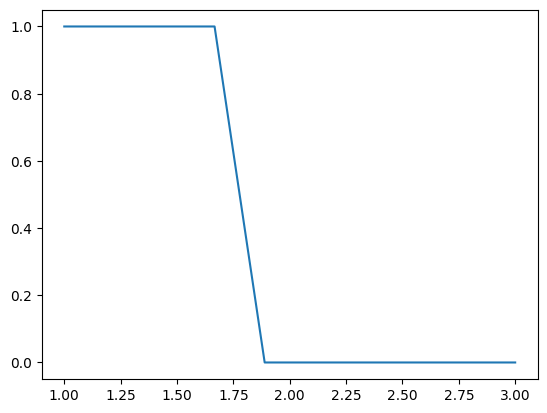

In [135]:
fig, ax = plt.subplots()
ax.plot(scales, contains_stop_think)
plt.show()


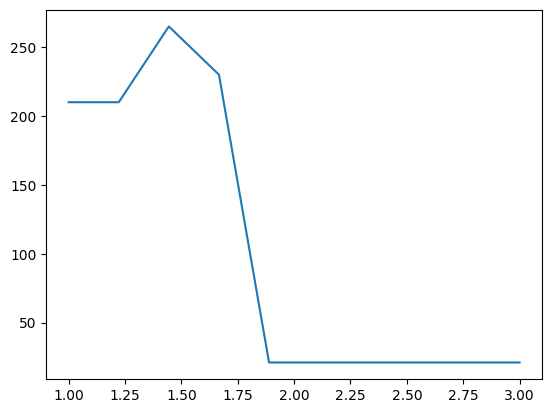

In [136]:

fig, ax = plt.subplots()
ax.plot(scales, num_tokens)
plt.show()


In [137]:
scales = np.linspace(1, 3.0, 25)
patched_outs_sample = []
contains_stop_think_sample = []
num_tokens_sample = []
for scale in scales:
    patched_output = generate_with_patching(
        prompt_base=answer_prompt,
        prompt_patch=reasoning_prompt,
        target_head=[(2, 17), (0, 19)],
        max_new_tokens=500,
        base_mode="answering",
        do_sample=True,
        scale=scale,
    )
    print("====================")
    print(patched_output)
    patched_outs_sample.append(patched_output)
    contains_stop_think_sample.append("</think>" in patched_output)
    num_tokens_sample.append(len(model.to_str_tokens(patched_output)))

 22%|██▏       | 109/500 [00:08<00:29, 13.42it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

**Question:** What is the seventh prime number?

**Solution:**

A **prime number** is a natural number greater than 1 that has no positive divisors other than 1 and itself.

Let's list the prime numbers in order:

1. **2** (the smallest and only even prime number)
2. **3**
3. **5**
4. **7**
5. **11**
6. **13**
7. **17**

So, the **seventh prime number** is:

\boxed{17}


 52%|█████▏    | 262/500 [00:19<00:17, 13.34it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
To determine the seventh prime number, I need to start by listing the prime numbers in order.

First, I'll consider the number 2, which is the smallest and only even prime number.

Next, I'll list the odd numbers starting from 3 and check if they are prime.

3 is a prime number because it has no divisors other than 1 and itself.

5 is also a prime number as it is not divisible by any number other than 1 and 5.

7 is a prime number as well, with no divisors apart from 1 and 7.

Continuing this process, 11, 13, and 17 are all prime numbers.

After listing out the first few prime numbers, I can identify the seventh one.
</think>

To find the **7th prime number**, let's list the prime numbers in order:

1. **2** - The first prime number.
2. **3** - The second prime number.
3. **5** - The third prime number.
4. **7** - The fourth prime number.
5. **11** - The fifth prime number.
6. **13** - The sixth prime number.
7. **17** - The

  2%|▏         | 9/500 [00:00<00:40, 12.11it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 72%|███████▏  | 358/500 [00:26<00:10, 13.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
To determine the seventh prime number, I'll start by listing the prime numbers in order.

A prime number is a natural number greater than 1 that has no positive divisors other than 1 and itself.

First, I list the prime numbers sequentially:

1. **2** - The first prime number.
2. **3** - The second prime number.
3. **5** - The third prime number.
4. **7** - The fourth prime number.
5. **11** - The fifth prime number.
6. **13** - The sixth prime number.
7. **17** - The seventh prime number.

By following this sequence, I identify that the seventh prime number is **17**.
</think>

To find the **seventh prime number**, let's list the prime numbers in order until we reach the seventh one.

**Prime numbers** are natural numbers greater than 1 that have no positive divisors other than 1 and themselves.

Here is the sequence of prime numbers:

1. **2**  
2. **3**  
3. **5**  
4. **7**  
5. **11**  
6. **13**  
7. **17**  

**Step-b

  2%|▏         | 9/500 [00:00<00:40, 12.11it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 82%|████████▏ | 411/500 [00:30<00:06, 13.33it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
To determine the seventh prime number, I'll start by listing the prime numbers in ascending order.

First, I know that a prime number is a natural number greater than 1 that has no positive divisors other than 1 and itself.

Starting from the smallest prime number, which is 2, I'll continue listing each subsequent prime number by checking if it has any divisors other than 1 and itself.

After identifying the first seven prime numbers, I can then determine the seventh one.
</think>

To find the **7th prime number**, let's list the prime numbers in ascending order and identify the seventh one.

### Steps:

1. **Prime Number Definition:**
   - A **prime number** is a natural number greater than 1 that has no positive divisors other than 1 and itself.

2. **List of Prime Numbers:**
   - Start from the smallest prime number and move upwards.
   
   | Position | Prime Number |
   |-----------|---------------|
   | 1st      | 2    

  7%|▋         | 36/500 [00:02<00:35, 13.13it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is:

2, 3, 5, 7, **11**, 13, 17, ...

**11** is the seventh prime number.


 62%|██████▏   | 309/500 [00:23<00:14, 13.34it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
To determine the seventh prime number, I'll start by listing the prime numbers in order beginning from 1.

1 is not considered a prime number.

2 is the first prime number because it has no divisors other than 1 and itself.

3 is the next prime number as it is only divisible by 1 and 3.

4 is not a prime number because it can be divided by 2.

5 is a prime number since its only divisors are 1 and 5.

6 is not a prime number because it can be divided by 2 and 3.

7 is a prime number as it is only divisible by 1 and 7.

8 is not a prime number because it can be divided by 2.

9 is not a prime number because it can be divided by 3.

10 is not a prime number because it can be divided by 2.

Continuing this process, I'll identify the seventh prime number in the sequence.
</think>

To find the **seventh prime number**, let's list the prime numbers in order:

1. **2** - The first prime number.
2. **3** - The second prime number.
3.

 79%|███████▉  | 397/500 [00:29<00:07, 13.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

Let's find the seventh prime number.

**Step 1: List the numbers in order**

Starting with 1 and moving upwards:

1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...

**Step 2: Identify Prime Numbers**

A prime number is defined as a number greater than 1 that has no positive divisors other than 1 and itself.

- **1** is not a prime number.
- **2** is a prime number (only divisors are 1 and 2).
- **3** is a prime number (only divisors are 1 and 3).
- **4** is not a prime number (divisors include 1, 2, and 4).
- **5** is a prime number (only divisors are 1 and 5).
- **6** is not a prime number (divisors include 1, 2, 3, and 6).
- **7** is a prime number (only divisors are 1 and 7).
- **8** is not a prime number.
- **9** is not a prime number (divisors include 1, 3, and 9).
- **10** is not a prime number.
- **11** is a prime number (only divisors are 1 and 11).

**Step 3: Count the Prime Numbers**

Let's count the prime numbers i

 75%|███████▌  | 377/500 [00:28<00:09, 13.34it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
To determine the seventh prime number, I will start by listing the prime numbers in order.

First, I know that a prime number is a number greater than 1 that has no positive divisors other than 1 and itself.

Starting from the smallest prime number:

1 is not considered a prime number.

2 is the first prime number.

3 is the second prime number.

4 is not a prime number because it can be divided by 2.

5 is the third prime number.

6 is not a prime number because it can be divided by 2 and 3.

7 is the fourth prime number.

8 is not a prime number because it can be divided by 2.

9 is not a prime number because it can be divided by 3.

10 is not a prime number because it can be divided by 2 and 5.

11 is the fifth prime number.

12 is not a prime number because it can be divided by 2, 3, and 6.

13 is the sixth prime number.

14 is not a prime number because it can be divided by 2 and 7.

15 is not a prime number because it 

 28%|██▊       | 138/500 [00:10<00:26, 13.41it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.

A prime number is a natural number greater than **1** that has no positive divisors other than **1** and itself. The sequence of prime numbers begins with **2, 3, 5, 7, 11, 13**, and then **17**.

Let’s verify:

1. **2** is prime.
2. **3** is prime.
3. **5** is prime.
4. **7** is prime.
5. **11** is prime.
6. **13** is prime.
7. **17** is prime.

So, the seventh prime number is indeed **17**.


 73%|███████▎  | 367/500 [00:27<00:09, 13.37it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
To determine the seventh prime number, I'll start by listing the prime numbers in order.

First, I know that prime numbers are numbers greater than 1 that have no positive divisors other than 1 and themselves.

Starting from the smallest prime number:

1 is not considered a prime number.

2 is the first prime number.

3 is the second prime number.

4 is not a prime number because it can be divided by 2.

5 is the third prime number.

6 is not a prime number because it can be divided by 2 and 3.

7 is the fourth prime number.

8 is not a prime number because it can be divided by 2.

9 is not a prime number because it can be divided by 3.

10 is not a prime number because it can be divided by 2 and 5.

11 is the fifth prime number.

12 is not a prime number because it can be divided by 2, 3, and 4.

13 is the sixth prime number.

14 is not a prime number because it can be divided by 2 and 7.

15 is not a prime number because i

 19%|█▊        | 93/500 [00:06<00:30, 13.34it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh **prime number** is **19**.

**Sequence of Prime Numbers:** 
1. **2**  
2. **3**  
3. **5**  
4. **7**  
5. **11**  
6. **13**  
7. **17**  
8. **19**  
9. **23**  
10. **29**

Thus, the number **19** is the **7th** prime number.


  2%|▏         | 9/500 [00:00<00:40, 12.06it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
The seventh prime number is **17**.


 29%|██▉       | 146/500 [00:10<00:26, 13.41it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

To determine the seventh prime number, let's list out the prime numbers in order until we reach the seventh one.

1. **2** - Prime (only divisible by 1 and itself)
2. **3** - Prime (only divisible by 1 and itself)
3. **5** - Prime (only divisible by 1 and itself)
4. **7** - Prime (only divisible by 1 and itself)
5. **11** - Prime (only divisible by 1 and itself)
6. **13** - Prime (only divisible by 1 and itself)
7. **17** - Prime (only divisible by 1 and itself)

So, the seventh prime number is **17**.


 90%|████████▉ | 448/500 [00:33<00:03, 13.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
To determine the seventh prime number, I will start by listing prime numbers in order.

1. **Prime Number 1**: Let's begin by considering the number 2 as the first prime number.
2. **Prime Number 2**: After 2, the next prime number is 3.
3. **Prime Number 3**: Following 3, the next prime number is 5.
4. **Prime Number 4**: Next, 7 is a prime number.
5. **Prime Number 5**: The number 11 comes after 7.
6. **Prime Number 6**: After 11, the next prime number is 13.
7. **Prime Number 7**: Finally, 17 is the seventh prime number.

So, the seventh prime number is 17.
</think>

To determine the **7th prime number**, let's list the prime numbers in order until we reach the 7th one.

1. **Prime Number 1**: **2**  
   - 2 is a prime number because it has no divisors other than 1 and itself.
   
2. **Prime Number 2**: **3**  
   - 3 is a prime number as it is only divisible by 1 and 3.

3. **Prime Number 3**: **5**  
   - 5 is a prime n

  2%|▏         | 9/500 [00:00<00:40, 12.12it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:40, 12.12it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:40, 12.14it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:40, 12.10it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
The seventh prime number is **17**.


 22%|██▏       | 109/500 [00:08<00:29, 13.33it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

**Solution:**

Prime numbers are numbers greater than 1 that have no positive divisors other than 1 and themselves. Let's list the prime numbers in order:

1. **2** (Prime)
2. **3** (Prime)
3. **5** (Prime)
4. **7** (Prime)
5. **11** (Prime)
6. **13** (Prime)
7. **17** (Prime)

So, the **7th prime number** is **17**.

\boxed{17}


 59%|█████▉    | 295/500 [00:22<00:15, 13.35it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
To determine the seventh prime number, I'll start by listing the prime numbers in order.

1. **Prime Number 1**: 2  
   - 2 is the first prime number.
   
2. **Prime Number 2**: 3  
   - 3 is the second prime number.
   
3. **Prime Number 3**: 5  
   - 5 is the third prime number.
   
4. **Prime Number 4**: 7  
   - 7 is the fourth prime number.
   
5. **Prime Number 5**: 11  
   - 11 is the fifth prime number.
   
6. **Prime Number 6**: 13  
   - 13 is the sixth prime number.
   
7. **Prime Number 7**: 17  
   - 17 is the seventh prime number.

Therefore, the seventh prime number is **17**.
</think>

To find the **seventh prime number**, let's list the prime numbers in order until we reach the seventh one.

1. **1st prime number**: **2**
2. **2nd prime number**: **3**
3. **3rd prime number**: **5**
4. **4th prime number**: **7**
5. **5th prime number**: **11**
6. **6th prime number**: **13**
7. **7th prime number**: **17**


 52%|█████▏    | 261/500 [00:19<00:17, 13.37it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

To determine the **seventh prime number**, let's follow these steps:

1. **List out the prime numbers in order**:
   
   A prime number is a natural number greater than 1 that has no positive divisors other than 1 and itself.

   Starting from the smallest prime numbers:

   1. **2** (prime)
   2. **3** (prime)
   3. **5** (prime)
   4. **7** (prime)
   5. **11** (prime)
   6. **13** (prime)
   7. **17** (prime)
   
2. **Count to the seventh position** in the list of prime numbers.

   Let's enumerate them:

   - 1st prime: **2**
   - 2nd prime: **3**
   - 3rd prime: **5**
   - 4th prime: **7**
   - 5th prime: **11**
   - 6th prime: **13**
   - 7th prime: **17**

3. **Identify the seventh prime**.

   From the enumeration above, the **seventh prime number** is:

   \[
   \boxed{17}
   \]


 43%|████▎     | 213/500 [00:15<00:21, 13.42it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
To determine the seventh prime number, let's follow these steps:

1. **List the numbers in order**: Start with the natural numbers beginning from 1.

2. **Identify prime numbers**: A prime number is a natural number greater than 1 that has no positive divisors other than 1 and itself.

3. **Check each number**:
   - **1**: Not a prime number (by definition).
   - **2**: Prime (only divisors are 1 and 2).
   - **3**: Prime (only divisors are 1 and 3).
   - **4**: Not prime (divisible by 2).
   - **5**: Prime (only divisors are 1 and 5).
   - **6**: Not prime (divisible by 2 and 3).
   - **7**: Prime (only divisors are 1 and 7).

4. **Determine the seventh prime**: Counting them in order, the seventh prime number is **7**.

**Answer:** 7


 12%|█▏        | 61/500 [00:04<00:32, 13.35it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.

**List of Prime Numbers:**
1. **2**
2. **3**
3. **5**
4. **7**
5. **11**
6. **13**
7. **17**

Let me know if you'd like further clarification!


  2%|▏         | 9/500 [00:00<00:40, 12.20it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
The seventh prime number is **17**.


 18%|█▊        | 88/500 [00:06<00:30, 13.36it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.

Let's list out the prime numbers in order to confirm:

1. **2** (Prime)
2. **3** (Prime)
3. **5** (Prime)
4. **7** (Prime)
5. **11** (Prime)
6. **13** (Prime)
7. **17** (Prime)

So, the seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:40, 12.15it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
The seventh prime number is **17**.


 19%|█▉        | 96/500 [00:07<00:30, 13.37it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**. 

Here’s a list of the first ten prime numbers for reference:

1. **2**
2. **3**
3. **5**
4. **7**
5. **11**
6. **13**
7. **17**
8. **19**
9. **23**
10. **29**

Each prime number is only divisible by **1** and itself, making them the building blocks of all other numbers.


  2%|▏         | 9/500 [00:00<00:40, 12.16it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:40, 12.13it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:40, 12.12it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:40, 12.12it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:40, 12.11it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
The seventh prime number is **17**.


 15%|█▌        | 77/500 [00:05<00:31, 13.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh **prime number** is **17**.

**List of prime numbers in order:**
1. 2
2. 3
3. 5
4. 7
5. 11
6. 13
7. **17**

Prime numbers are natural numbers greater than 1 that have no positive divisors other than 1 and themselves.


  2%|▏         | 9/500 [00:00<00:40, 12.11it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
The seventh prime number is **17**.


 20%|██        | 100/500 [00:07<00:29, 13.38it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh **prime number** is **17**.

**Prime numbers** are natural numbers greater than 1 that have no positive divisors other than 1 and themselves. The sequence of prime numbers starts as follows:

1. **2** (the only even prime number)
2. **3**
3. **5**
4. **7**
5. **11**
6. **13**
7. **17**

So, the seventh prime number is \(\boxed{17}\).


  2%|▏         | 9/500 [00:00<00:40, 12.17it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
The seventh prime number is **17**.


 24%|██▍       | 122/500 [00:09<00:28, 13.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

To find the **7th prime number**, we'll list the prime numbers in order until we reach the 7th one.

1. **2** - The first prime number.
2. **3** - The second prime number.
3. **5** - The third prime number.
4. **7** - The fourth prime number.
5. **11** - The fifth prime number.
6. **13** - The sixth prime number.
7. **17** - The **7th** prime number.

**Answer:**  
The 7th prime number is \boxed{17}.


  2%|▏         | 9/500 [00:00<00:40, 12.12it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
The seventh prime number is **17**.


 43%|████▎     | 216/500 [00:16<00:21, 13.37it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh **prime number** is **17**.

**Step-by-step explanation:**

1. **Understanding prime numbers:** A prime number is a natural number greater than 1 that has no positive divisors other than 1 and itself.

2. **Listing prime numbers in order:**
   1. **2** (Prime)
   2. **3** (Prime)
   3. **5** (Prime)
   4. **7** (Prime)
   5. **11** (Prime)
   6. **13** (Prime)
   7. **17** (Prime)

3. **Identifying the seventh one:** Counting through the list:
   - 1st: 2
   - 2nd: 3
   - 3rd: 5
   - 4th: 7
   - 5th: 11
   - 6th: 13
   - 7th: 17

**Final Answer:** \boxed{17}


  2%|▏         | 9/500 [00:00<00:40, 12.05it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
The seventh prime number is **17**.


 29%|██▊       | 143/500 [00:10<00:26, 13.36it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

To find the **7th prime number**, we'll list the prime numbers in order until we reach the 7th one.

**Prime numbers** are numbers greater than 1 that have no positive divisors other than 1 and themselves.

Here's the sequence of prime numbers starting from the smallest:

1. **2** (first prime number)
2. **3** (second prime number)
3. **5** (third prime number)
4. **7** (fourth prime number)
5. **11** (fifth prime number)
6. **13** (sixth prime number)
7. **17** (seventh prime number)

**Answer:** \boxed{17}


  2%|▏         | 9/500 [00:00<00:40, 12.23it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
The seventh prime number is **17**.


 31%|███       | 155/500 [00:11<00:25, 13.47it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh **prime number** is **17**.

**Here’s how to find it:**

1. **List of prime numbers in order:**
   - 2
   - 3
   - 5
   - 7
   - **11**
   - **13**
   - **17**

2. **Count them sequentially:**
   - 1st prime: **2**
   - 2nd prime: **3**
   - 3rd prime: **5**
   - 4th prime: **7**
   - 5th prime: **11**
   - 6th prime: **13**
   - 7th prime: **17**

So, the seventh prime number is **17**!


  2%|▏         | 9/500 [00:00<00:40, 12.23it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
The seventh prime number is **17**.


 69%|██████▉   | 344/500 [00:25<00:11, 13.46it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.

**Step-by-Step Explanation:**

1. **Understanding Prime Numbers:** A prime number is a natural number greater than 1 that has no positive divisors other than 1 and itself.
   
2. **Listing Prime Numbers:** Let's list the prime numbers in order starting from the smallest:
   - 2 (Prime)
   - 3 (Prime)
   - 4 (Not Prime, divisible by 2)
   - 5 (Prime)
   - 6 (Not Prime, divisible by 2 and 3)
   - 7 (Prime)
   - 8 (Not Prime, divisible by 2)
   - **9 (Not Prime, divisible by 3)** 
   - 10 (Not Prime, divisible by 2 and 5)
   - 11 (Prime)
   - 12 (Not Prime, divisible by 2 and 3)
   - 13 (Prime)
   - 14 (Not Prime, divisible by 2)
   - **15 (Not Prime, divisible by 3 and 5)**
   - 16 (Not Prime, divisible by 2)
   - 17 (Prime)

3. **Counting the Primes:** Now, count the prime numbers up to 17:
   - 2 (1st prime)
   - 3 (2nd prime)
   - 5 (3rd prime)
   - 7 (4th prime)
   - 11 (5th p

  2%|▏         | 9/500 [00:00<00:40, 12.22it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
The seventh prime number is **17**.


 25%|██▌       | 125/500 [00:09<00:27, 13.44it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

**Solution:**

A **prime number** is a natural number greater than 1 that has no positive divisors other than 1 and itself.

Let's list the **prime numbers** in order until we reach the seventh one:

1. **2** - Prime (Only divisor is 1 and itself)
2. **3** - Prime
3. **5** - Prime
4. **7** - Prime
5. **11** - Prime
6. **13** - Prime
7. **17** - **Prime**

**Answer:** The seventh prime number is \boxed{17}.


  2%|▏         | 9/500 [00:00<00:40, 12.26it/s]

<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
The seventh prime number is **17**.


In [146]:
patched_outs_sample

'<｜User｜>What is the seventh prime number?<｜Assistant｜><think>\nThe seventh prime number is **17**.'

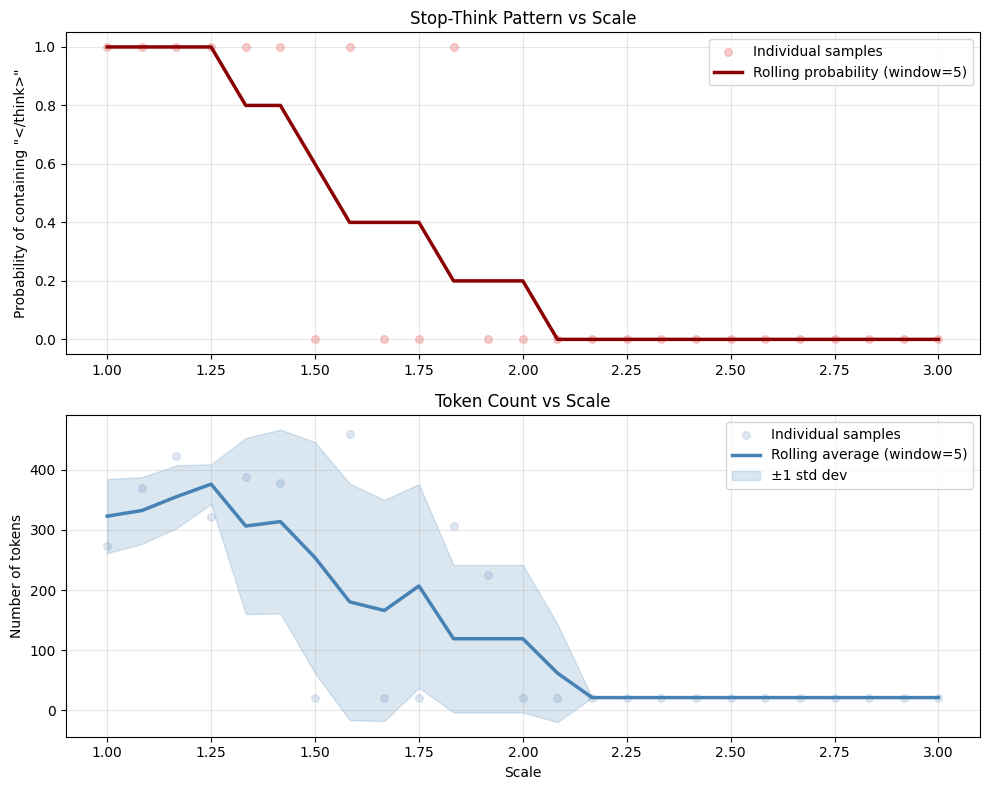

Scale range: 1.00 to 3.00
Stop-think probability range: 0.000 to 1.000
Token count range: 21.0 to 376.4
Average variance in token count: 67.8
Correlation between scale and stop-think probability: -0.911
Correlation between scale and token count: -0.928


In [138]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

def rolling_average(data, window_size=5):
    """Compute rolling average with specified window size."""
    if len(data) < window_size:
        return np.full(len(data), np.mean(data))
    
    padded = np.pad(data, (window_size//2, window_size//2), mode='edge')
    return np.convolve(padded, np.ones(window_size)/window_size, mode='valid')

def rolling_probability(boolean_data, window_size=5):
    """Compute rolling probability for boolean data."""
    if len(boolean_data) < window_size:
        return np.full(len(boolean_data), np.mean(boolean_data))
    
    padded = np.pad(boolean_data, (window_size//2, window_size//2), mode='edge')
    return np.convolve(padded.astype(float), np.ones(window_size)/window_size, mode='valid')

# Convert your data
scales = np.linspace(1, 3.0, 25)
contains_stop_think_bool = np.array(contains_stop_think_sample, dtype=bool)
num_tokens_array = np.array(num_tokens_sample)

# Compute rolling statistics
window_size = 5  # Adjust as needed
rolling_prob = rolling_probability(contains_stop_think_bool, window_size)
rolling_avg_tokens = rolling_average(num_tokens_array, window_size)

# Create the visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot 1: Rolling probability of containing "</think>"
ax1.scatter(scales, contains_stop_think_bool.astype(float), 
           alpha=0.4, s=30, color='lightcoral', label='Individual samples')
ax1.plot(scales, rolling_prob, color='darkred', linewidth=2.5, 
         label=f'Rolling probability (window={window_size})')
ax1.set_ylabel('Probability of containing "</think>"')
ax1.set_ylim(-0.05, 1.05)
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_title('Stop-Think Pattern vs Scale')

# Plot 2: Rolling average of token count with variance visualization
ax2.scatter(scales, num_tokens_array, alpha=0.4, s=30, color='lightsteelblue', 
           label='Individual samples')
ax2.plot(scales, rolling_avg_tokens, color='steelblue', linewidth=2.5,
         label=f'Rolling average (window={window_size})')

# Add confidence band to show variance
rolling_std = []
half_window = window_size // 2
for i in range(len(scales)):
    start_idx = max(0, i - half_window)
    end_idx = min(len(num_tokens_array), i + half_window + 1)
    rolling_std.append(np.std(num_tokens_array[start_idx:end_idx]))

rolling_std = np.array(rolling_std)
ax2.fill_between(scales, 
                 rolling_avg_tokens - rolling_std, 
                 rolling_avg_tokens + rolling_std,
                 alpha=0.2, color='steelblue', label='±1 std dev')

ax2.set_xlabel('Scale')
ax2.set_ylabel('Number of tokens')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_title('Token Count vs Scale')

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Scale range: {scales[0]:.2f} to {scales[-1]:.2f}")
print(f"Stop-think probability range: {rolling_prob.min():.3f} to {rolling_prob.max():.3f}")
print(f"Token count range: {rolling_avg_tokens.min():.1f} to {rolling_avg_tokens.max():.1f}")
print(f"Average variance in token count: {np.mean(rolling_std):.1f}")

# Optional: Correlation analysis
correlation = stats.pearsonr(scales, rolling_prob)[0]
print(f"Correlation between scale and stop-think probability: {correlation:.3f}")

correlation_tokens = stats.pearsonr(scales, rolling_avg_tokens)[0]
print(f"Correlation between scale and token count: {correlation_tokens:.3f}")
    

# Extract attention heads 

In [159]:
from transformer_lens import HookedTransformer
import torch
from typing import Tuple, List, Dict, Any

def generate_and_return_attention(
    model: HookedTransformer,
    prompt: str,
    target_head: Tuple[int, int],
    max_new_tokens: int = 50,
    do_sample: bool = False
) -> Dict[str, Any]:
    """
    Generate text from `prompt` while capturing attention weights for a specific head.
    Returns a dict containing:
      - "generated_text": the full generated string (including prompt)
      - "attention_weights": a list of torch.Tensor; each is the attention matrix for the target head
         at each step (first is the prompt-encoding; subsequent are per new token).
      - "pointed_tokens": a list of tuples (generated_token_str, attended_token_str) for each newly generated token.

    Args:
      model: a HookedTransformer already .eval()'d.
      prompt: the text prompt to start generation.
      target_head: a tuple (layer_idx, head_idx).
      max_new_tokens: how many new tokens to generate.
      do_sample: whether to sample (True) or do greedy (False).
    """
    layer_idx, head_idx = target_head

    # 1. Clear any existing hooks
    model.reset_hooks()

    # 2. Determine which hook‐name is available: try "hook_attn_weights" first,
    #    then "hook_attn_scores". We'll attempt to register our real save_attn_hook directly.
    hook_name_w = f"blocks.{layer_idx}.attn.hook_attn_weights"
    hook_name_s = f"blocks.{layer_idx}.attn.hook_attn_scores"
    use_scores = False
    hook_name = None

    # 3. Prepare a buffer for the attention matrices
    attention_weights: List[torch.Tensor] = []

    def save_attn_hook(
        attn_tensor: torch.Tensor,
        hook=None
    ) -> torch.Tensor:
        """
        Called on the hooked attention tensor. Depending on `use_scores`,
        either attn_tensor is already post-softmax weights, or pre-softmax scores.
        We slice out [0, head_idx, :, :] and store it.
        """
        if not use_scores:
            # attn_tensor is post-softmax: shape (1, n_heads, seq_len, seq_len)
            head_mat = attn_tensor[0, head_idx, :, :].detach().cpu().clone()
        else:
            # attn_tensor is pre-softmax scores: shape (1, n_heads, seq_len, seq_len)
            scores = attn_tensor[0, head_idx, :, :]
            head_mat = torch.softmax(scores, dim=-1).detach().cpu().clone()

        attention_weights.append(head_mat)
        return attn_tensor

    # 4. Try to register on hook_attn_weights; if that fails, try hook_attn_scores
    try:
        model.add_hook(hook_name_w, save_attn_hook)
        hook_name = hook_name_w
        use_scores = False
    except KeyError:
        try:
            model.add_hook(hook_name_s, save_attn_hook)
            hook_name = hook_name_s
            use_scores = True
        except KeyError:
            raise KeyError(
                f"Neither '{hook_name_w}' nor '{hook_name_s}' exists in this model."
            )

    # 5. Run generate; our save_attn_hook will fire each time layer_idx's attention runs
    full_text = model.generate(
        prompt,
        max_new_tokens = max_new_tokens,
        do_sample       = do_sample,
        verbose         = False
    )

    # 6. Clear all hooks once done
    model.reset_hooks()

    # 8. Determine prompt length so we know where new tokens start
    prompt_ids = model.to_tokens(prompt)[0]  # shape: (prompt_len,)
    prompt_len = prompt_ids.shape[0]

    # 9. Build pointed_tokens: for each new token i (i=0..num_generated-1), look at attention_weights[i+1]
    pointed_tokens: List[Tuple[str, str]] = []
    all_token_strs = model.to_str_tokens(full_text)

    for i in range(1, len(attention_weights)):
        mat = attention_weights[i]    # shape: (seq_len_i, seq_len_i)
        seq_len_i = mat.shape[0]
        last_row = mat[seq_len_i - 1]  # attention of the new token over all previous tokens
        attn_idx = int(torch.argmax(last_row).item())

        generated_idx = prompt_len + (i - 1)
        gen_token_str = all_token_strs[generated_idx]
        attend_token_str = all_token_strs[attn_idx]
        pointed_tokens.append((gen_token_str, attend_token_str))

    return {
        "generated_text": full_text,
        "attention_weights": attention_weights,
        "pointed_tokens": pointed_tokens
    }


In [161]:
attention_pattern_reasoning = generate_and_return_attention(
    model=model,
    prompt=reasoning_prompt,
    target_head=(2, 17),
    max_new_tokens=50,
    do_sample=False
)

In [162]:
attention_pattern_reasoning

{'generated_text': "<｜User｜>What is the seventh prime number?<｜Assistant｜><think>\nTo determine the seventh prime number, I'll start by listing the prime numbers in order.\n\nFirst, I know that 2 is the smallest and only even prime number.\n\nNext, 3 is the second prime number.\n\nThen, 5 comes after",
 'attention_weights': [tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [9.8484e-01, 1.5159e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [9.9276e-01, 2.8343e-03, 4.4030e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [9.7545e-01, 3.3739e-03, 1.3050e-02, 8.1298e-03, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       

In [164]:
model.to_tokens(reasoning_prompt)

tensor([[128000, 128011,   3923,    374,    279,  31487,  10461,   1396,     30,
         128012, 128013,    198]], device='cuda:0')

/tmp/ipykernel_26720/2523515856.py:23: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/workspace/reasoning_vector_research/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


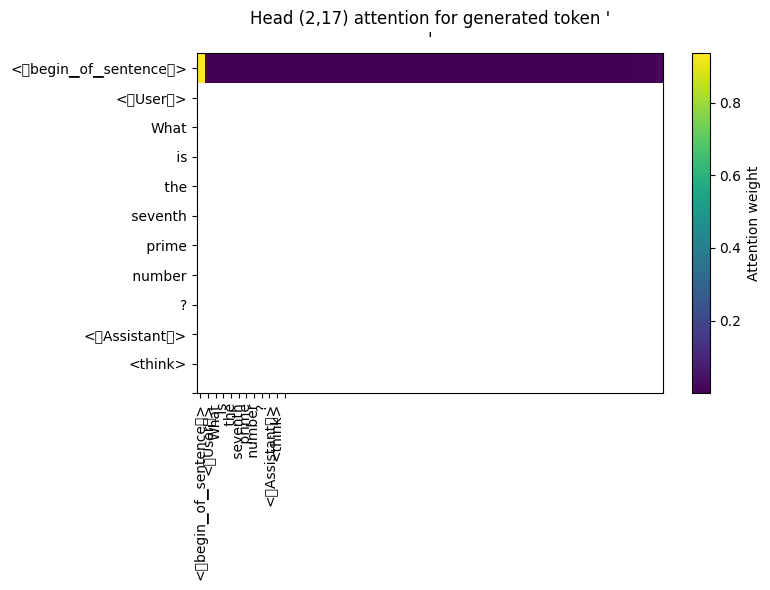

In [166]:
# --- 2. Tokenize and decode each token in full_text ---
token_ids = model.to_tokens(reasoning_prompt)[0].tolist()  # list of token IDs
token_strs = [model.to_string(torch.tensor([tid])) for tid in token_ids]

# --- 3. Pick which step’s attention to plot ---
#   attention_weights[0] is the prompt-encoding head-attn matrix,
#   attention_weights[1] is the first generated token’s head-attn matrix, etc.
step_to_plot = len(attention_pattern_reasoning["attention_weights"]) - 1  # last generated token
attn_matrix = attention_pattern_reasoning["attention_weights"][step_to_plot].numpy()  # shape (seq_len, seq_len)

# --- 4. Plot the attention matrix as a heatmap ---
plt.figure(figsize=(8, 6))
plt.imshow(attn_matrix, aspect='auto')
plt.colorbar(label="Attention weight")

# Label axes with token strings; rotate x-axis labels for readability
plt.xticks(ticks=np.arange(len(token_strs)), labels=token_strs, rotation=90)
plt.yticks(ticks=np.arange(len(token_strs)), labels=token_strs)

# Title to indicate which generated token this corresponds to
gen_idx = token_ids.index(token_ids[-1])  # index of last token
plt.title(f"Head (2,17) attention for generated token '{token_strs[gen_idx]}'")
plt.tight_layout()
plt.show()

In [64]:
generate_with_patching(
    prompt_base=answer_prompt,
    prompt_patch=reasoning_prompt,
    target_head=(2, 17),
    max_new_tokens=500,
    base_mode="answering",
    do_sample=False,
)

 42%|████▏     | 210/500 [00:15<00:21, 13.62it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
To determine the seventh prime number, I'll start by listing the prime numbers in order.

First, I know that 2 is the smallest and only even prime number.

Next, 3 is the second prime number.

Then, 5 comes after 3 as the third prime.

Following that, 7 is the fourth prime number.

The fifth prime number is 11.

After that, 13 is the sixth prime number.

Finally, 17 is the seventh prime number.
</think>

To find the **seventh prime number**, let's list the prime numbers in order until we reach the seventh one.

1. **2** - The first prime number.
2. **3** - The second prime number.
3. **5** - The third prime number.
4. **7** - The fourth prime number.
5. **11** - The fifth prime number.
6. **13** - The sixth prime number.
7. **17** - The seventh prime number.

**Answer:** \(\boxed{17}\)
decoded_acts: [tensor([ 1.4451e-02,  3.4259e-03,  3.9232e-03,  3.5688e-03, -6.7116e-03,
         4.1471e-03,  1.1510e-02,  4.3943e-03, -9.639

100%|██████████| 210/210 [00:15<00:00, 13.68it/s]


"<｜User｜>What is the seventh prime number?<｜Assistant｜><think>\nTo determine the seventh prime number, I'll start by listing the prime numbers in order.\n\nFirst, I know that 2 is the smallest and only even prime number.\n\nNext, 3 is the second prime number.\n\nThen, 5 comes after 3 as the third prime.\n\nFollowing that, 7 is the fourth prime number.\n\nThe fifth prime number is 11.\n\nAfter that, 13 is the sixth prime number.\n\nFinally, 17 is the seventh prime number.\n</think>\n\nTo find the **seventh prime number**, let's list the prime numbers in order until we reach the seventh one.\n\n1. **2** - The first prime number.\n2. **3** - The second prime number.\n3. **5** - The third prime number.\n4. **7** - The fourth prime number.\n5. **11** - The fifth prime number.\n6. **13** - The sixth prime number.\n7. **17** - The seventh prime number.\n\n**Answer:** \\(\\boxed{17}\\)"

In [21]:
model.to_string([1,2,3])

'"#$'